In [1]:
# load the hypergraph
import yaml
import logging
import itertools
import os
import sys
import random

from scipy import sparse
import numpy as np
import seaborn as sns
import networkx as nx
import community

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.data import Data

from cell.utils import link_prediction_performance
from cell.cell import Cell, EdgeOverlapCriterion, LinkPredictionCriterion
from cell.graph_statistics import compute_graph_statistics

from utils import load_graphs
from cliques import compute_cliques

In [2]:
class GNN(torch.nn.Module):
    def __init__(self, node_features):
        super().__init__()
        # GCN initialization
        self.conv1 = SAGEConv(node_features, 128)
        self.conv2 = SAGEConv(128, 128)
        self.bn = torch.nn.BatchNorm1d(128)
        
        # self.conv2 = GCNConv(128, 128)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.bn(x)
        x = self.conv2(x, edge_index)

        return x


def save_hypergraph(hg, path):
    with open(path, 'w') as f:
        for edge in hg:
            f.write(' '.join(map(str,edge)) + '\n')


def hypergraph_metrics(hg):
    # original hypergraph
    num_edges = len(hg)
    nodes = set()
    node_degrees = {}
    for edge in hg:
        for node in edge:
            nodes.add(node)
            node_degrees[node] = node_degrees.get(node, 0) + 1
    num_nodes = len(nodes)
    
    # density
    density = num_edges / num_nodes

    # Average size
    avg_size = sum(len(edge) for edge in hg) / num_edges

    # Average degree
    avg_degree = sum(node_degrees.values()) / num_nodes


    # projected graph
    G = nx.Graph()
    # Add all nodes from the hypergraph
    nodes = set(node for edge in hg for node in edge)
    G.add_nodes_from(nodes)
    # For each hyperedge, create a clique
    for edge in hg:
        # Add edges between all pairs of nodes in the hyperedge
        G.add_edges_from(itertools.combinations(edge, 2))
    
    part_G = community.best_partition(G)
    mod_G = community.modularity(part_G, G)


    # bipartite graph
    B = nx.Graph()
    # Add nodes for the original vertices (left set)
    left_nodes = set(node for edge in hg for node in edge)
    B.add_nodes_from(left_nodes, bipartite=0)
    # Add nodes for the hyperedges (right set)
    right_nodes = [f'e{i}' for i in range(len(hg))]
    B.add_nodes_from(right_nodes, bipartite=1)
    # Add edges between vertices and their corresponding hyperedges
    for i, edge in enumerate(hg):
        for node in edge:
            B.add_edge(node, f'e{i}')


    part_B = community.best_partition(B)
    mod_B = community.modularity(part_B, B)

    return {
        "density": density,
        "average_size": avg_size,
        "average_degree": avg_degree,
        "coefficient": nx.average_clustering(G),
        "G_modularity": mod_G,
        "B_modularity": mod_B
    }


In [3]:

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

config  = yaml.safe_load(open('./config.yml'))
# config['dataset'] = 'NDC-classes'
graphs = load_graphs(config, logger)
config['beta'] = len(graphs['simplicies_train']) * 10

cliques = compute_cliques(graphs, config, logger)

# data = np.array([len(s) for s in graphs['simplicies_train']])
# hist, bins = np.histogram(data, bins=np.linspace(1, 8, 8))
# sns.displot(data)

number of simplices: 234760
number of unique simplices: 25027
Node index should begin with 0, reindexing the hypergraphs ...
number of nodes in construct graph 998


INFO:root:Finish loading graphs.
INFO:root:Nodes train: 998
INFO:root:Simplicies train: 25027
INFO:root:Start computing cliques
INFO:root:Found cache for max cliques train
INFO:root:Number of maximum cliques:237231
INFO:root:Optimizing clique sampler .. 


Number of maximum cliques: 237231


INFO:root:Found cache for rho.
INFO:root:[(2, 2), (1, 1), (3, 2), (2, 1), (4, 2), (3, 1), (5, 2), (3, 3), (6, 2), (4, 1), (4, 4), (4, 3), (7, 2), (5, 3), (5, 5), (6, 3), (5, 1), (6, 6), (8, 2)]
INFO:root:Optimize Clique Sampler: #hyperedges collected:11276, recall: 0.45055340232548846, efficiency:0.04505534023254885


(0, 0), (116, 116), (135, 135), (951, 631), (1183, 742), (4957, 2127), (5773, 2356), (18853, 4925), (19125, 4966), (54525, 7685), (57041, 7840), (57670, 7875), (60186, 7956), (137088, 10009), 

INFO:root:Clique analysis done.


(150168, 10267), (151476, 10284), (198676, 10886), (205216, 10946), (207576, 10964), 


In [4]:
from torch_geometric.nn import Node2Vec

graph_adjacency_matrix, weighted_graph_adjacency_matrix = nx.to_numpy_array(graphs['G_train'], nodelist=sorted(graphs['G_train'].nodes())), nx.to_numpy_array(graphs['G_weighted'], nodelist=sorted(graphs['G_train'].nodes()))

edge_index = torch.tensor(np.array(graph_adjacency_matrix.nonzero()), dtype=torch.long)
data = Data(edge_index=edge_index)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Node2Vec(
    data.edge_index,
    embedding_dim=50,
    walks_per_node=10,
    walk_length=20,
    context_size=10,
    p=1.0,
    q=1.0,
    num_negative_samples=1,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)

pos_rw, neg_rw = next(iter(loader))

model.train()
for pos_rw, neg_rw in loader:
    optimizer.zero_grad()
    loss = model.loss(pos_rw.to(device), neg_rw.to(device))
    loss.backward()
    optimizer.step()
    # print(loss.item())

embeddings = model()
embeddings.requires_grad = False


In [5]:
graph_adjacency_matrix, weighted_graph_adjacency_matrix = nx.to_numpy_array(graphs['G_train'], nodelist=sorted(graphs['G_train'].nodes())), nx.to_numpy_array(graphs['G_weighted'], nodelist=sorted(graphs['G_train'].nodes()))
edge_index = torch.tensor(np.array(graph_adjacency_matrix.nonzero()), dtype=torch.long)
edge_value = weighted_graph_adjacency_matrix[graph_adjacency_matrix.nonzero()]


# training for GNN
data = Data(x=embeddings, edge_index=edge_index)
model = GNN(50)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    src, dst = edge_index
    score = (out[src] * out[dst]).sum(dim=-1)
    loss = F.mse_loss(score, torch.tensor(edge_value, dtype=torch.float))
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'epoch: {epoch}, loss: {loss.item()}')
# edge_index = torch.tensor(np.array(graph.nonzero()), dtype=torch.long)

# training for CELL
sparse_matrix = sparse.csr_matrix(graph_adjacency_matrix)
cell_model = Cell(A=sparse_matrix,
             H=10,
             callbacks=[EdgeOverlapCriterion(invoke_every=10, edge_overlap_limit=.80)])
cell_model.train(steps=400,
            optimizer_fn=torch.optim.Adam,
            optimizer_args={'lr': 0.1,
                            'weight_decay': 1e-7})

epoch: 9, loss: 138.48568725585938
epoch: 19, loss: 90.21084594726562
epoch: 29, loss: 63.88017654418945
epoch: 39, loss: 47.88198471069336
epoch: 49, loss: 37.84208679199219
epoch: 59, loss: 30.87794303894043
epoch: 69, loss: 25.948978424072266
epoch: 79, loss: 22.284454345703125
epoch: 89, loss: 19.514482498168945
epoch: 99, loss: 17.358173370361328
epoch: 109, loss: 15.613862991333008
epoch: 119, loss: 14.18787956237793
epoch: 129, loss: 12.996821403503418
epoch: 139, loss: 11.985884666442871
epoch: 149, loss: 11.114208221435547
epoch: 159, loss: 10.354058265686035
epoch: 169, loss: 9.69638442993164
epoch: 179, loss: 9.6353120803833
epoch: 189, loss: 8.797338485717773
epoch: 199, loss: 8.182903289794922


/Users/weihuang/anaconda3/envs/hygen/lib/python3.12/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/weihuang/anaconda3/envs/hygen/lib/python3.12/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Step:  10/400 Loss: 5.93953 Edge-Overlap: 0.415 Total-Time: 0
Step:  20/400 Loss: 5.59130 Edge-Overlap: 0.461 Total-Time: 1
Step:  30/400 Loss: 5.47989 Edge-Overlap: 0.476 Total-Time: 2
Step:  40/400 Loss: 5.42970 Edge-Overlap: 0.495 Total-Time: 2
Step:  50/400 Loss: 5.40264 Edge-Overlap: 0.502 Total-Time: 3
Step:  60/400 Loss: 5.38574 Edge-Overlap: 0.509 Total-Time: 4
Step:  70/400 Loss: 5.37379 Edge-Overlap: 0.512 Total-Time: 5
Step:  80/400 Loss: 5.36473 Edge-Overlap: 0.513 Total-Time: 5
Step:  90/400 Loss: 5.35762 Edge-Overlap: 0.516 Total-Time: 6
Step: 100/400 Loss: 5.35190 Edge-Overlap: 0.519 Total-Time: 7
Step: 110/400 Loss: 5.34724 Edge-Overlap: 0.519 Total-Time: 7
Step: 120/400 Loss: 5.34336 Edge-Overlap: 0.515 Total-Time: 8
Step: 130/400 Loss: 5.34007 Edge-Overlap: 0.522 Total-Time: 9
Step: 140/400 Loss: 5.33721 Edge-Overlap: 0.521 Total-Time: 9
Step: 150/400 Loss: 5.33469 Edge-Overlap: 0.525 Total-Time: 10
Step: 160/400 Loss: 5.33246 Edge-Overlap: 0.522 Total-Time: 10
Step: 

In [ ]:
import utils
# from utils import lazy_clique_edge_cover
from importlib import reload

# reconstruct the hypergraph by clique cover
# YOU GUY!!!!!!!!!!!!!!!!!!!!!!
# BAD API!!!!!!!!!!!!!!!!!!!!!!
# G = graphs['G_weighted']
# weighted_adjacency_matrix = nx.to_numpy_array(G, nodelist=sorted(G.nodes()))

# # sampling cliques
# os.remove(f'{config['data_dir']}/{config['dataset']}/cliques_train.pkl')
# os.remove(f'{config['data_dir']}/{config['dataset']}/rho.pkl')

# generate WLIG
generated_graph = cell_model.sample_graph()
graph_prime = generated_graph.A
edge_index_prime = torch.tensor(graph_prime.nonzero(), dtype=torch.long)
x = embeddings
data_prime = Data(x=x, edge_index = edge_index_prime)
out = model(data_prime)
src, dst = edge_index_prime
score = (out[src] * out[dst]).sum(dim=-1)
weight = score.detach().numpy()
weight[weight <= 1] = 1
weight = np.rint(weight).astype(int)
print('weight:', weight)

weighted_graph_prime = np.copy(graph_prime)
weighted_graph_prime[weighted_graph_prime.nonzero()] = weight

# sample cliques
cliques = compute_cliques(graphs, config, logger)
sample_cliques_table = cliques['children_cliques_train']
# print(sample_cliques_table)
sample_cliques = []
for v in sample_cliques_table.values():
    sample_cliques = sample_cliques + v
sample_cliques = [list(c) for c in sample_cliques]
set_sample_cliques = list(set([tuple(sorted(e)) for e in sample_cliques]))
print(f'len of origin: {len(sample_cliques)}, len of deduplicates: {len(set_sample_cliques)}')

# reconstruct hyperedges
reconstruct_hyperedges = utils.lazy_clique_edge_cover(np.copy(weighted_graph_prime), set_sample_cliques, len(graphs['simplicies_train']))
# random.shuffle(set_sample_hyperedges)
# sample_clique_sizes = [len(c) for c in set_sample_cliques]
# data = np.array(sample_clique_sizes)
# hist, bins = np.histogram(data, bins=np.linspace(0, 5, 6))
# sns.displot(data)
# reconstruct_hyperedges = utils.lazy_clique_edge_cover(weighted_adjacency_matrix, set_sample_cliques, len(graphs['simplicies_train']))
# reconstruct_hyperedges_sizes = [len(e) for e in reconstruct_hyperedges]
# data = np.array(reconstruct_hyperedges_sizes)
# sns.displot(data)
set_reconstruct_hyperedges = set([tuple(sorted(e)) for e in reconstruct_hyperedges])
print(f'len: {len(graphs['simplicies_train'])}, {graphs['simplicies_train']}')
print(f'len: {len(set_reconstruct_hyperedges)}, {set_reconstruct_hyperedges}')
# save_hypergraph(set_reconstruct_hyperedges, f'./baseline/HyperPLR/{config['dataset']}/reconstruct_hyperedges_{i}.txt')


print('original hypergraph', hypergraph_metrics(graphs['simplicies_train']))
print('reconstructed hypergraph', hypergraph_metrics(set_reconstruct_hyperedges))

6.993481006177685 6.698044301853305
14.001628136023172 10.410322346433384
Mean of A: 6.993481006177685, Mean of B: 6.698044301853305
Std Dev of A: 14.001628136023172, Std Dev of B: 10.410322346433384


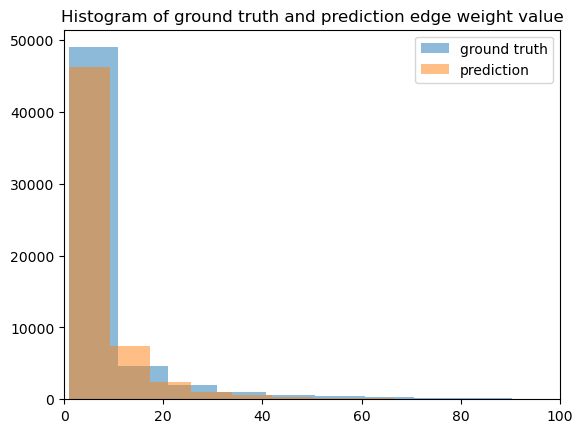

In [33]:
# bias analysis
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, mannwhitneyu

A = edge_value
B = weight

mean_A, mean_B = np.mean(A), np.mean(B)
std_A, std_B = np.std(A), np.std(B)

print(mean_A, mean_B)
print(std_A, std_B)

print(f"Mean of A: {mean_A}, Mean of B: {mean_B}")
print(f"Std Dev of A: {std_A}, Std Dev of B: {std_B}")

# Histogram
plt.hist(A, bins=30, alpha=0.5, label='ground truth')
plt.hist(B, bins=30, alpha=0.5, label='prediction')
plt.legend()
plt.xlim(0, 100)
plt.title("Histogram of ground truth and prediction edge weight value")
plt.show()


In [ ]:
import os
import networkx as nx
import community
import itertools
from collections import defaultdict
import pickle


def hypergraph_metrics(hg):
    # original hypergraph
    num_edges = len(hg)
    nodes = set()
    node_degrees = {}
    for edge in hg:
        for node in edge:
            nodes.add(node)
            node_degrees[node] = node_degrees.get(node, 0) + 1
    num_nodes = len(nodes)
    
    # density
    density = num_edges / num_nodes

    # Average size
    avg_size = sum(len(edge) for edge in hg) / num_edges

    # Average degree
    avg_degree = sum(node_degrees.values()) / num_nodes


    # projected graph
    G = nx.Graph()
    # Add all nodes from the hypergraph
    nodes = set(node for edge in hg for node in edge)
    G.add_nodes_from(nodes)
    # For each hyperedge, create a clique
    for edge in hg:
        # Add edges between all pairs of nodes in the hyperedge
        G.add_edges_from(itertools.combinations(edge, 2))
    
    part_G = community.best_partition(G)
    mod_G = community.modularity(part_G, G)


    # bipartite graph
    B = nx.Graph()
    # Add nodes for the original vertices (left set)
    left_nodes = set(node for edge in hg for node in edge)
    B.add_nodes_from(left_nodes, bipartite=0)
    # Add nodes for the hyperedges (right set)
    right_nodes = [f'e{i}' for i in range(len(hg))]
    B.add_nodes_from(right_nodes, bipartite=1)
    # Add edges between vertices and their corresponding hyperedges
    for i, edge in enumerate(hg):
        for node in edge:
            B.add_edge(node, f'e{i}')


    part_B = community.best_partition(B)
    mod_B = community.modularity(part_B, B)

    return {
        "density": density,
        "average_size": avg_size,
        "average_degree": avg_degree,
        "coefficient": nx.average_clustering(G),
        "G_modularity": mod_G,
        "B_modularity": mod_B
    }

def load_hypergraph(path, model):
    with open(path, 'r') as f:
        hg = f.readlines()
    if model == 'HyperDK00' or model == 'HyperDK11' or model == 'HyperPLR':
        hg = [list(map(int, e.split())) for e in hg]
    else:
        hg = [list(map(int, e.split(','))) for e in hg]
    return hg

metric_baseline = defaultdict(list)


def get_metrics_baseline(graph_path):
    models = os.listdir(graph_path)
    for model in models:
        graphs = os.listdir(f'{graph_path}/{model}')
        for graph in graphs:
            hypergraphs = os.listdir(f'{graph_path}/{model}/{graph}')
            for hypergraph in hypergraphs:
                hg = load_hypergraph(f'{graph_path}/{model}/{graph}/{hypergraph}', model)
                metric = hypergraph_metrics(hg)
                print(metric)
                metric_baseline[(graph, model)].append(metric)

    return metric_baseline

        # for hypergraphs in gen_model:
        #     for hg_file in hypergraphs:
        #         hg = load_hypergraph(hg_file)
        #         metric = hypergraph_metrics(hg)
        #         print(metric)

metric_baseline = get_metrics_baseline('./generate_graphs')
metric_baseline


In [ ]:
# pickle.dump(metric_baseline, open('./metric_baseline.pkl', 'wb'))